# Installs and imports

In [1]:
# install requirements
!pip install datasets
!pip install gensim
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [1]:
#imports
from datasets import load_dataset
from functools import reduce
from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import defaultdict

# Load datasets

In [2]:
usp = load_dataset("lecslab/usp-igt")
ddo = load_dataset("lecslab/ddo-igt")

In [3]:
def split_glosses(row):
    """
    Split glosses into individual morphemes.
    :param row: row of the dataset
    :return: row with glosses split into individual morphemes
    """
    word_glosses = row['glosses'].split()
    glosses = [word.split("-") for word in word_glosses]
    glosses = reduce(lambda a,b:a+["[SEP]"]+b, glosses)
    glosses = [gloss if gloss.isupper() else "STEM" for gloss in glosses]
    row['glosses_split'] = [gloss for gloss in glosses if gloss != '']
    return row

In [4]:
usp = usp.map(split_glosses)
ddo = ddo.map(split_glosses)

In [5]:
usp_glosses = usp['train']['glosses_split']
ddo_glosses = ddo['train']['glosses_split']
print(usp_glosses[0-5])
usp_all_glosses = Counter()
for row in usp_glosses:
  usp_all_glosses.update(row)
print(usp_all_glosses)
ddo_all_glosses = Counter()
for row in ddo_glosses:
  ddo_all_glosses.update(row)
print(ddo_all_glosses)

['STEM', 'SAB', '[SEP]', 'STEM', '[SEP]', 'STEM', 'PART', '[SEP]', 'DIM', '[SEP]', 'STEM', '[SEP]', 'PREP', 'SREL', 'PL']
Counter({'[SEP]': 32199, 'STEM': 28493, 'E3S': 3118, 'INC': 2742, 'PART': 2582, 'COM': 2304, 'PL': 2083, 'DEM': 2018, 'SREL': 1817, 'PREP': 1473, 'ENF': 1464, 'E1P': 1370, 'NEG': 1130, 'SC': 1018, 'CONJ': 975, 'ART': 800, 'DIM': 797, 'E1S': 709, 'DIR': 687, 'EXS': 661, 'E2S': 564, 'E3': 385, 'A1S': 347, 'INT': 343, 'AP': 339, 'PAS': 276, 'ITS': 244, 'AFI': 207, 'SAB': 158, 'MOV': 141, 'A2S': 127, 'PP': 127, 'TAM': 124, 'AFE': 112, 'A1P': 110, 'AGT': 100, 'SV': 88, 'ITR': 73, 'IMP': 66, 'COND': 59, 'PRG': 42, 'INS': 37, 'E3P': 32, 'CLAS': 32, 'GNT': 20, 'CAU': 19, 'E2P': 16, 'E2': 16, 'MED': 13, 'PRON': 12, 'ADV': 10, 'RFX': 8, 'TRN': 7, 'NUM': 5, 'E1': 2, 'A2P': 2, 'APLI': 1, 'REC': 1})
Counter({'STEM': 69242, '[SEP]': 67800, 'PFV.CVB': 6654, 'PST.UNW': 5448, 'TOP': 4660, 'ERG': 4422, 'III': 4260, 'QUOT': 3542, 'IV': 3284, 'GEN1': 2498, 'II': 2462, 'LAT': 2276, 'PL'

# Word2Vec embeddings

In [ ]:
model = Word2Vec(sentences=usp_glosses, vector_size=50, window=5, min_count=1, sg=0) #sg 0 for CBOW or 1 for skip-gram


# SVD embeddings
PPMI and SVD

In [6]:
def compute_ppmi(cooccurrence_matrix):
    """
    Compute the Positive Pointwise Mutual Information (PPMI) matrix.

    Args:
        cooccurrence_matrix (numpy.ndarray): Co-occurrence matrix.

    Returns:
        numpy.ndarray: PPMI matrix.
    """
    # Ensure the matrix is numpy array
    cooccurrence_matrix = np.array(cooccurrence_matrix, dtype=np.float64)

    # Compute the total sum of the matrix
    total_sum = np.sum(cooccurrence_matrix)

    # Compute the sum of rows and columns
    row_sums = np.sum(cooccurrence_matrix, axis=1, keepdims=True)
    col_sums = np.sum(cooccurrence_matrix, axis=0, keepdims=True)

    # Compute the expected probabilities
    expected = np.outer(row_sums, col_sums) / total_sum

    # Compute PPMI values
    with np.errstate(divide='ignore', invalid='ignore'):
        pmi = np.log2(cooccurrence_matrix * total_sum / expected)
        pmi[np.isinf(pmi) | np.isnan(pmi)] = 0
        ppmi = np.maximum(pmi, 0)

    return ppmi

def compute_svd(ppmi_matrix, embedding_dim):
    """
    Compute the Singular Value Decomposition (SVD) for dimensionality reduction.

    Args:
        ppmi_matrix (numpy.ndarray): PPMI matrix.
        embedding_dim (int): Desired dimensionality for embeddings.

    Returns:
        numpy.ndarray: Reduced dimensional embeddings.
    """
    svd = TruncatedSVD(n_components=embedding_dim)
    embeddings = svd.fit_transform(ppmi_matrix)
    return embeddings

def build_cooccurrence_matrix(data, separator='[SEP]', window_size=2):
    """
    Build a co-occurrence matrix from a list of morpheme glosses with a sliding window.

    Args:
        data (list of list of str): List of rows containing morpheme glosses.
        separator (str): Token used to split morpheme groups.
        window_size (int): The size of the sliding window for co-occurrence.

    Returns:
        numpy.ndarray, list: Co-occurrence matrix and list of unique morphemes.
    """
    # Get all unique morphemes excluding the separator
    all_morphemes = [morpheme for row in data for morpheme in row if morpheme != separator]
    unique_morphemes = list(set(all_morphemes))
    morpheme_to_idx = {morpheme: idx for idx, morpheme in enumerate(unique_morphemes)}

    # Initialize co-occurrence matrix
    size = len(unique_morphemes)
    cooccurrence_matrix = np.zeros((size, size), dtype=np.float64)

    # Populate co-occurrence matrix
    for row in data:
        filtered_row = [morpheme for morpheme in row if morpheme != separator]
        for i in range(len(filtered_row)):
            for j in range(max(0, i - window_size), min(len(filtered_row), i + window_size + 1)):
                if i != j:
                    idx1, idx2 = morpheme_to_idx[filtered_row[i]], morpheme_to_idx[filtered_row[j]]
                    cooccurrence_matrix[idx1, idx2] += 1

    return cooccurrence_matrix, unique_morphemes

In [7]:
def get_svd_embeddings(glosses, window_size, vector_size):
  cooccurrence_matrix, morphemes = build_cooccurrence_matrix(glosses, window_size=window_size)

  ppmi_matrix = compute_ppmi(cooccurrence_matrix)

  embeddings = compute_svd(ppmi_matrix, vector_size)

  return embeddings, morphemes

Example:

In [34]:
# Parameters
window_size_ = 2  # Sliding window size
embedding_dim = 5  # Desired embedding dimensionality

# Build co-occurrence matrix
usp_svd, usp_morphs = get_svd_embeddings(usp_glosses, window_size_, embedding_dim)
usp_svd

array([[ 3.25791608e+01,  2.66100580e+01,  4.32476202e+00,
        -2.90451586e+00, -5.64872347e+00],
       [ 5.34780229e+01,  1.88450780e+01,  2.09457840e+01,
        -1.73459589e+01, -2.15064918e+01],
       [ 3.52205073e+01,  3.15270476e+01,  1.29601116e+01,
        -1.23064562e+01,  3.28545824e+00],
       [ 1.01591662e+02, -7.40859635e+00, -2.12838186e+01,
        -2.29004892e+01,  1.00366629e+01],
       [ 1.27812851e+01,  4.22558789e+00,  4.69384016e+00,
        -1.36085023e+01, -2.67090095e+00],
       [ 3.08322214e+01,  1.12355313e+01,  9.19032753e+00,
         7.67970795e+00,  1.95221064e+00],
       [ 6.80939191e+01,  2.28790516e+01,  3.23028623e+01,
         1.46015158e+01,  9.65230469e+00],
       [ 5.01699934e+01,  1.88662995e+01,  3.61113552e+01,
        -1.93590110e+01,  7.71622103e-01],
       [ 4.99329792e+01,  2.08644247e+01, -1.32578420e+01,
        -1.06416903e+01,  1.16676857e+01],
       [ 1.06130297e+01,  1.08396578e+01,  2.78512882e+00,
        -8.08247606e+00

In [31]:
usp_morphs

['ADV',
 'PRG',
 'E2P',
 'DIM',
 'REC',
 'PRON',
 'IMP',
 'CLAS',
 'E2',
 'APLI',
 'PREP',
 'A1S',
 'EXS',
 'GNT',
 'CAU',
 'ITR',
 'COM',
 'INS',
 'A2S',
 'PP',
 'SC',
 'COND',
 'AP',
 'MOV',
 'SAB',
 'NUM',
 'E3P',
 'E1S',
 'E1',
 'A1P',
 'TRN',
 'ENF',
 'DIR',
 'A2P',
 'INC',
 'AFI',
 'STEM',
 'CONJ',
 'INT',
 'NEG',
 'MED',
 'E2S',
 'SV',
 'PL',
 'SREL',
 'DEM',
 'AGT',
 'PAS',
 'E3',
 'TAM',
 'RFX',
 'ITS',
 'E3S',
 'PART',
 'ART',
 'AFE',
 'E1P']

# Load linguitic feature vectors

In [8]:
def read_linguistic_feature_csv(path, gloss_counter):
  df = pd.read_csv(path)
  df = df.drop(columns="Class")
  feature_vectors = {row['Gloss']: row.iloc[1:].values.astype(float) for _, row in df.iterrows() if gloss_counter.get(row['Gloss'], 0) >=5 }
  return feature_vectors

In [ ]:
ddo_features = read_linguistic_feature_csv("./ddo_features_dims.csv", ddo_all_glosses)
ddo_features

{'AD.ABL': array([1., 1., 0., 0., 0., 0., 0.]),
 'AD.ESS': array([1., 2., 0., 0., 0., 0., 0.]),
 'AD.LAT': array([1., 3., 0., 0., 0., 0., 0.]),
 'AD.VERS': array([1., 4., 0., 0., 0., 0., 0.]),
 'AD.VERS.DIST': array([1., 4., 1., 0., 0., 0., 0.]),
 'ADV': array([0., 0., 0., 0., 0., 0., 0.]),
 'ANT.CVB': array([0., 0., 0., 0., 0., 0., 0.]),
 'APUD.ABL': array([2., 1., 0., 0., 0., 0., 0.]),
 'APUD.ESS': array([2., 2., 0., 0., 0., 0., 0.]),
 'APUD.LAT': array([2., 3., 0., 0., 0., 0., 0.]),
 'APUD.VERS': array([2., 4., 0., 0., 0., 0., 0.]),
 'APUD.VERS.DIST': array([2., 4., 1., 0., 0., 0., 0.]),
 'ATTR': array([0., 0., 0., 0., 0., 0., 0.]),
 'ATTR.OBL': array([0., 0., 0., 0., 0., 0., 0.]),
 'CAUS': array([0., 0., 0., 0., 0., 0., 0.]),
 'CNC.CVB': array([0., 0., 0., 0., 0., 0., 0.]),
 'CND': array([0., 0., 0., 0., 0., 0., 0.]),
 'CND.CVB': array([0., 0., 0., 0., 0., 0., 0.]),
 'CND.CVB.IRR': array([0., 0., 0., 0., 0., 0., 0.]),
 'CNTR': array([0., 0., 0., 0., 0., 0., 0.]),
 'COND': array([0.

In [9]:
usp_features = read_linguistic_feature_csv("./usp_features_v1.csv", usp_all_glosses)
usp_features

{'A1P': array([1., 1., 2.]),
 'A1S': array([1., 1., 1.]),
 'A2S': array([2., 1., 1.]),
 'ADV': array([0., 0., 0.]),
 'AFE': array([0., 0., 0.]),
 'AFI': array([0., 0., 0.]),
 'AGT': array([0., 0., 0.]),
 'AP': array([0., 0., 0.]),
 'ART': array([0., 0., 0.]),
 'CAU': array([0., 0., 0.]),
 'CLAS': array([0., 0., 0.]),
 'COM': array([0., 0., 0.]),
 'COND': array([0., 0., 0.]),
 'CONJ': array([0., 0., 0.]),
 'DEM': array([0., 0., 0.]),
 'DIM': array([0., 0., 0.]),
 'DIR': array([0., 0., 0.]),
 'E1P': array([1., 2., 2.]),
 'E1S': array([1., 2., 1.]),
 'E2': array([2., 2., 0.]),
 'E2P': array([2., 2., 2.]),
 'E2S': array([2., 2., 1.]),
 'E3': array([3., 2., 0.]),
 'E3P': array([3., 2., 2.]),
 'E3S': array([3., 2., 1.]),
 'ENF': array([0., 0., 0.]),
 'EXS': array([0., 0., 0.]),
 'GNT': array([0., 0., 0.]),
 'IMP': array([0., 0., 0.]),
 'INC': array([0., 0., 0.]),
 'INS': array([0., 0., 0.]),
 'INT': array([0., 0., 0.]),
 'ITR': array([0., 0., 0.]),
 'ITS': array([0., 0., 0.]),
 'MED': array(

# Calculate similarities

In [18]:
def cos_sim(a, b):
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    # Comprobar si alguna de las normas es cero para evitar división por cero
    if norm_a == 0 or norm_b == 0:
        return 0.0  # Similitud cero si alguno de los vectores es nulo

    return np.dot(a, b) / (norm_a * norm_b)

In [11]:
def compute_sim_correlation(svd, svd_embeddings, svd_morphemes, feature_vectors, w2v):
    """
    Compute correlation of similarities between embeddings and linguistic feature vectors.
    """
    gloss_combos = []
    ling_similarity = []
    embed_similarity = []
    random_similarity = []

    # Iterate over all unique gloss pairs
    for gloss1, gloss2 in combinations(feature_vectors.keys(), 2):
      if gloss1 == gloss2:
        continue
      #ling_sim = cos_sim(np.array(feature_vectors[gloss1]), np.array(feature_vectors[gloss2]))
      ling_sim = cos_sim(feature_vectors[gloss1], feature_vectors[gloss2])
      if ling_sim == 0:
        # they do not share at least 1 feature
        continue

      # else continue
      gloss_combos.append(f"{gloss1, gloss2}")
      # similarity between linguistic feature vectors
      ling_similarity.append(ling_sim)
      if svd:
        # similarity between svd embedding vectors
        embed_similarity.append(cos_sim(svd_embeddings[svd_morphemes.index(gloss1)], svd_embeddings[svd_morphemes.index(gloss2)]))
      else:
        # similarity between w2v embedding vectors
        embed_similarity.append(cos_sim(w2v.wv.get_vector(gloss1), w2v.wv.get_vector(gloss2)))

      # similarity with a random vector
      random_gloss = random.choice([gloss for gloss in feature_vectors.keys() if gloss != gloss1])
      if svd:
        random_similarity.append(cos_sim(svd_embeddings[svd_morphemes.index(gloss1)],svd_embeddings[svd_morphemes.index(random_gloss)]))
      else:
        random_similarity.append(cos_sim(w2v.wv.get_vector(gloss1), w2v.wv.get_vector(random_gloss)))


    # Compute correlations
    # print(ling_similarity)
    # print(embed_similarity)
    true_sim = np.corrcoef((ling_similarity), (embed_similarity))[0, 1]
    random_sim = np.corrcoef((ling_similarity),(random_similarity))[0, 1]
    return true_sim, random_sim, gloss_combos

In [ ]:
usp_filtered_features = {gloss: vector for gloss, vector in usp_features.items() if gloss in usp_morphs}
true_correlation, random_correlation, gloss_combinations = compute_sim_correlation(True, usp_svd, usp_morphs, usp_filtered_features, None)

print(f"True Similarity Correlation: {true_correlation}")
print(f"Random Similarity Correlation: {random_correlation}")
print("Gloss Combinations and their Similarities:")
# for combo in gloss_combinations:
#     print(combo)

# Try parameters

In [12]:
from collections import defaultdict

In [13]:
def parameter_sweep(data, feature_vectors, vector_sizes, window_sizes):
    results = {'model': [], 'vector_size': [], 'window_size': [], 'correlation': []}
    most_similar_glosses_w2v = defaultdict(lambda: defaultdict(int))
    most_similar_glosses_w2v_sg = defaultdict(lambda: defaultdict(int))
    most_similar_glosses_svd = defaultdict(lambda: defaultdict(int))
    filtered_vectors = feature_vectors
    for vector_size in tqdm(vector_sizes):
        for window_size in window_sizes:
            # SVD
            # Build co-occurrence matrix
            svd_embeddings, svd_morphemes = get_svd_embeddings(data, window_size, vector_size)

            #svd_morphemes = {morpheme: svd_embeddings[idx] for idx, morpheme in enumerate(svd_morphemes)}
            #filtered_vectors = {gloss: vector for gloss, vector in feature_vectors.items() if gloss in svd_morphemes}
            correlation = compute_sim_correlation(True, svd_embeddings, svd_morphemes, filtered_vectors, None)

            results['model'].append('svd')
            results['vector_size'].append(vector_size)
            results['window_size'].append(window_size)
            results['correlation'].append(correlation)

            # compute most similar glosses
            for i, embedding in enumerate(svd_embeddings):
              max_similarity = -1
              most_similar_gloss = None
              # find closest for each
              for j, other_embedding in enumerate(svd_embeddings):
                if i==j:
                  continue
                similarity = cos_sim(embedding, other_embedding)
                if similarity > max_similarity:
                  max_similarity = similarity
                  most_similar_gloss = svd_morphemes[j]
              # after the loop append result for each morpheme
              most_similar_glosses_svd[svd_morphemes[i]][most_similar_gloss] += 1


            # Word2Vec
            w2v_model = Word2Vec(sentences=data, vector_size=vector_size, window=window_size, min_count=5, sg=0)#sg 0 for CBOW or 1 for skip-gram
            #filtered_vectors = {gloss: vector for gloss, vector in feature_vectors.items() if gloss in w2v_model.wv.index_to_key}
            correlation = compute_sim_correlation(False, None, None, filtered_vectors, w2v_model)

            # save results
            results['model'].append('w2v-cbow')
            results['vector_size'].append(vector_size)
            results['window_size'].append(window_size)
            results['correlation'].append(correlation)

            # compute most similar gloss
            for gloss in w2v_model.wv.key_to_index.keys():
              most_similar_glosses_w2v[gloss][w2v_model.wv.most_similar(gloss)[0][0]] += 1

            w2v_model = Word2Vec(sentences=data, vector_size=vector_size, window=window_size, min_count=5, sg=1)#sg 0 for CBOW or 1 for skip-gram
            #filtered_vectors = {gloss: vector for gloss, vector in feature_vectors.items() if gloss in w2v_model.wv.index_to_key}
            correlation = compute_sim_correlation(False, None, None, filtered_vectors, w2v_model)

            results['model'].append('w2v-skipgram')
            results['vector_size'].append(vector_size)
            results['window_size'].append(window_size)
            results['correlation'].append(correlation)

            # compute most similar gloss
            for gloss in w2v_model.wv.key_to_index.keys():
              most_similar_glosses_w2v_sg[gloss][w2v_model.wv.most_similar(gloss)[0][0]] += 1

    return pd.DataFrame(results), most_similar_glosses_svd, most_similar_glosses_w2v, most_similar_glosses_w2v_sg

In [14]:
vector_sizes = range(5, 51)  # Vector sizes from 5 to 50
window_sizes = range(1, 11)  # Window sizes from 1 to 10

usp_features = read_linguistic_feature_csv("./usp_features_v1.csv", usp_all_glosses)
ddo_features = read_linguistic_feature_csv("./ddo_features_v1.csv", ddo_all_glosses)


In [19]:
usp_results, ms_svd, ms_w2v, ms_w2v_sg = parameter_sweep(usp_glosses, usp_features, vector_sizes, window_sizes)

100%|██████████| 46/46 [08:27<00:00, 11.02s/it]


In [20]:
usp_results

,model,vector_size,window_size,correlation
0,svd,5,1,"(-0.10674699219016681, -0.22461728598283237, [..."
1,w2v-cbow,5,1,"(0.019365973118737452, -0.13541989441367072, [..."
2,w2v-skipgram,5,1,"(0.10452433424446916, -0.23690962996791828, [(..."
3,svd,5,2,"(-0.22198947584416479, -0.11266200571665838, [..."
4,w2v-cbow,5,2,"(-0.04691124559422023, -0.1140281589340813, [(..."
...,...,...,...,...
1375,w2v-cbow,50,9,"(0.1978492283313971, -0.012378341041160961, [(..."
1376,w2v-skipgram,50,9,"(0.060656343942979446, -0.12362140571275872, [..."
1377,svd,50,10,"(-0.16622221207028176, -0.1906175114497636, [(..."
1378,w2v-cbow,50,10,"(0.16314552342370475, -0.1319182524528138, [('..."


In [21]:
ddo_results , ms_svd_ddo, ms_w2v_ddo, ms_w2v_sg_ddo  = parameter_sweep(ddo_glosses, ddo_features, vector_sizes, window_sizes)

100%|██████████| 46/46 [16:59<00:00, 22.16s/it]


In [22]:
ddo_results

,model,vector_size,window_size,correlation
0,svd,5,1,"(0.1833485433564656, 0.021502228998311702, [('..."
1,w2v-cbow,5,1,"(0.05270212590782614, 0.017946165149016022, [(..."
2,w2v-skipgram,5,1,"(0.05033590698207711, 0.012373341697848783, [(..."
3,svd,5,2,"(0.16605148019749355, -0.0025206007115240437, ..."
4,w2v-cbow,5,2,"(0.06315689929439687, -0.05753734106343304, [(..."
...,...,...,...,...
1375,w2v-cbow,50,9,"(0.0626523252796198, -0.025907886722453127, [(..."
1376,w2v-skipgram,50,9,"(0.11781322132701459, -0.031054051420595506, [..."
1377,svd,50,10,"(0.17417243821689588, 0.05076776653196283, [('..."
1378,w2v-cbow,50,10,"(0.08003182126176832, -0.04764102128825057, [(..."


# Visualize results

## Methods

In [23]:
def visualize_results(results, vector_sizes, window_sizes):
    plt.figure(figsize=(14, 10))
    results['correlation_value'] = results['correlation'].apply(lambda x: x[0] if isinstance(x, tuple) else x)
    min = results['correlation_value'].min()
    max = results['correlation_value'].max()

    for idx, model in enumerate(results['model'].unique(), 1):
        subset = results[results['model'] == model]
        pivot_table = subset.pivot(index='window_size', columns='vector_size', values='correlation_value')

        plt.subplot(3, 1, idx)
        plt.title(f"{model.upper()} Correlations")
        sns.heatmap(pivot_table, annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Correlation'}, vmin=min, vmax=max)
        plt.ylabel('Window Size')
        plt.xlabel('Vector Size')

    plt.tight_layout()
    plt.show()

In [46]:
def boxplots(df):

  df['correlation_value'] = df['correlation'].apply(lambda x: x[0])
  df['random_correlation'] = df['correlation'].apply(lambda x: x[1])

  # Create a boxplot for each model
  plt.figure(figsize=(6, 6))
  sns.boxplot(data=df, x='model', y='correlation_value')

  #
  plt.title("Boxplots of Correlation for each Model")
  plt.xlabel("Model")
  plt.ylabel("Correlation Value")
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout()
  plt.show()

In [49]:
def get_stats(df):
    stats = df.groupby('model')['correlation_value'].agg(
        max='max',
        min='min',
        mean='mean',
        median='median',
        std='std'
    )
    stats2 = df.groupby('model')['random_correlation'].agg(
        max='max',
        min='min',
        mean='mean',
        median='median',
        std='std'
    )

    # print results
    print("Stats for each model:")
    print(stats)
    print("\nStats for random correlations:")
    print(stats2)

In [42]:
def get_closest_elements(data):
    closest_elements = {}
    for key, inner_dict in data.items():
        # Encontrar el elemento con el mayor valor
        closest_element = max(inner_dict, key=inner_dict.get)
        closest_elements[key] = closest_element
    return closest_elements

## Usp resutls

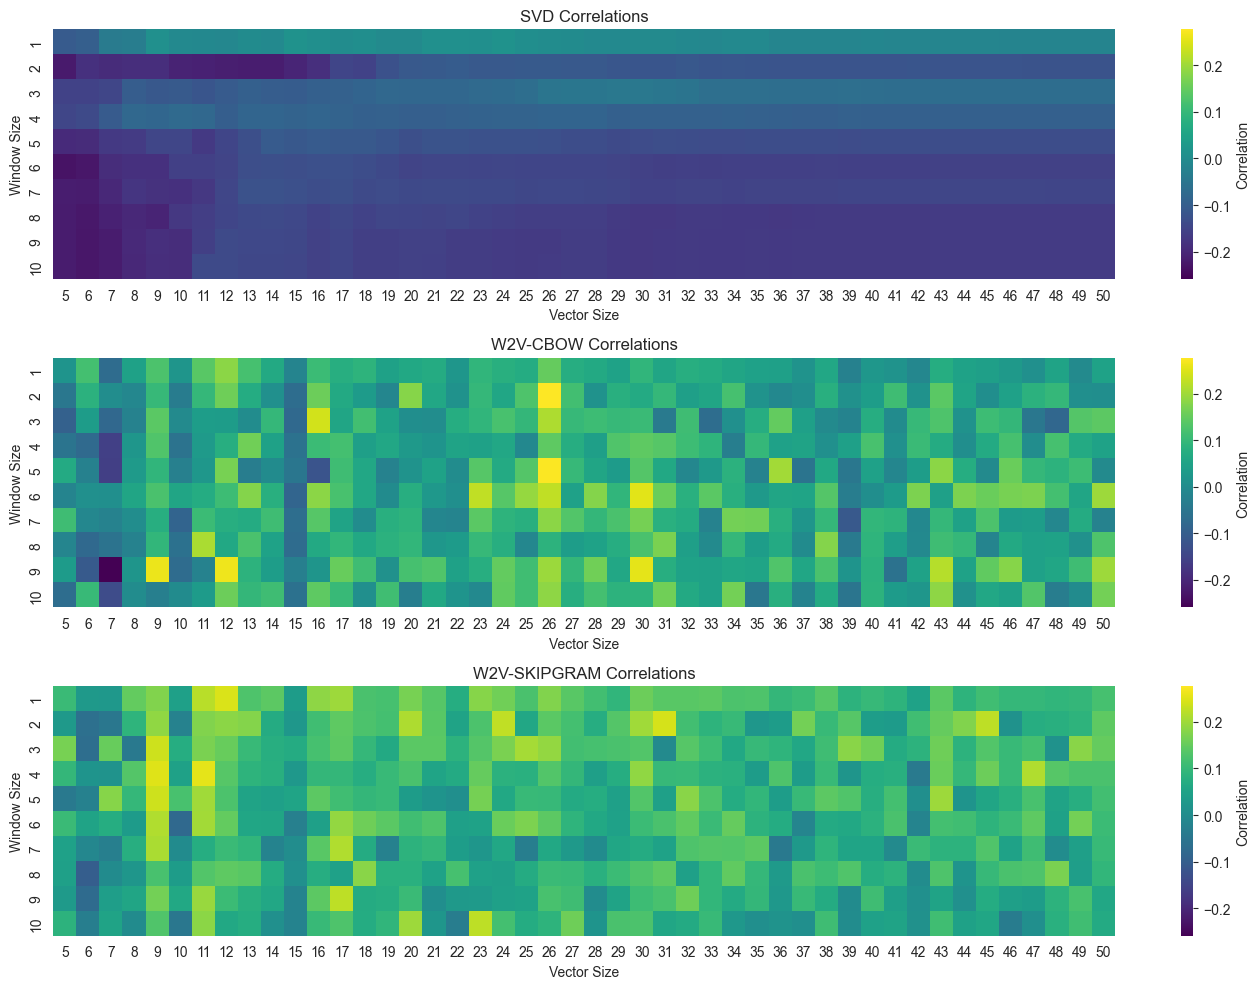

In [43]:
visualize_results(usp_results, vector_sizes, window_sizes)

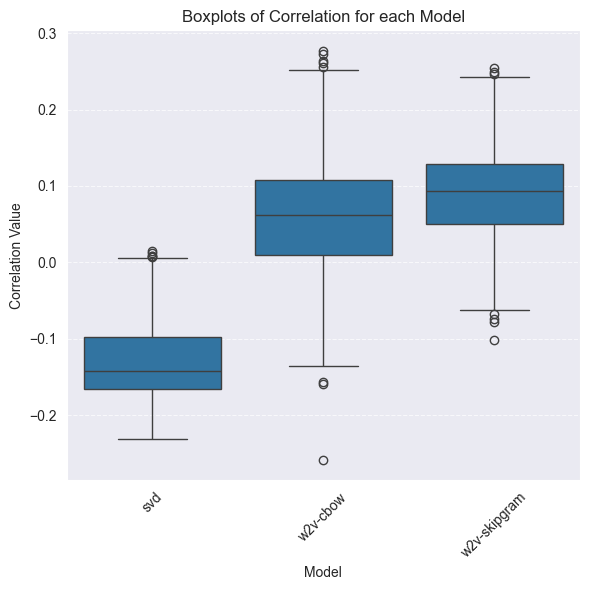

In [47]:
boxplots(usp_results)

In [50]:
get_stats(usp_results)

Stats for each model:
                   max       min      mean    median       std
model                                                         
svd           0.014875 -0.231618 -0.127461 -0.142730  0.052920
w2v-cbow      0.276895 -0.258785  0.061103  0.061613  0.074068
w2v-skipgram  0.254625 -0.101483  0.090299  0.093721  0.061630

Stats for random correlations:
                   max       min      mean    median       std
model                                                         
svd           0.294987 -0.307846 -0.033186 -0.036382  0.118459
w2v-cbow      0.416297 -0.352792  0.012160  0.001709  0.126651
w2v-skipgram  0.408034 -0.291294 -0.009801 -0.011314  0.116191


In [60]:
closest_svd = get_closest_elements(ms_svd)
closest_w2v = get_closest_elements(ms_w2v)
closest_w2v_sg = get_closest_elements(ms_w2v_sg)

In [61]:
headers = ["Gloss", "SVD", "W2V", "W2V SG"]
rows = []
for element in closest_svd.keys():
    rows.append([element, closest_svd.get(element, "-"), closest_w2v.get(element, "-"), closest_w2v_sg.get(element, "-")])
print(tabulate(rows, headers=headers, tablefmt="grid"))


+---------+-------+-------+----------+
| Gloss   | SVD   | W2V   | W2V SG   |
+=========+=======+=======+==========+
| TRN     | E1    | INS   | E2       |
+---------+-------+-------+----------+
| E1S     | ART   | E2S   | E2S      |
+---------+-------+-------+----------+
| PART    | DEM   | AFI   | AFI      |
+---------+-------+-------+----------+
| PP      | E3    | AGT   | AGT      |
+---------+-------+-------+----------+
| SREL    | STEM  | SC    | SC       |
+---------+-------+-------+----------+
| A2S     | AFI   | A1P   | A1P      |
+---------+-------+-------+----------+
| ITS     | ART   | AFI   | COND     |
+---------+-------+-------+----------+
| E1P     | PART  | AP    | E3       |
+---------+-------+-------+----------+
| PAS     | E3    | ITR   | ITR      |
+---------+-------+-------+----------+
| E3P     | E2P   | ITR   | E2       |
+---------+-------+-------+----------+
| MOV     | SAB   | TAM   | AGT      |
+---------+-------+-------+----------+
| CLAS    | GNT   | INS  

In [62]:
headers = ["Gloss", "SVD", "W2V", "W2V SG"]
rows = []
for element in closest_svd.keys():
    if closest_svd.get(element, "-")=="-" or  closest_w2v.get(element, "-")=="-" or closest_w2v_sg.get(element, "-")=="-":
        pass
    else:
        rows.append([element, closest_svd.get(element, "-"), closest_w2v.get(element, "-"), closest_w2v_sg.get(element, "-")])

# Order the rows alfabetically
rows_sorted = sorted(rows, key=lambda x: x[0])
print(tabulate(rows_sorted, headers=headers, tablefmt="grid"))

+---------+-------+-------+----------+
| Gloss   | SVD   | W2V   | W2V SG   |
+=========+=======+=======+==========+
| A1P     | AP    | A2S   | A2S      |
+---------+-------+-------+----------+
| A1S     | E2S   | PAS   | E1S      |
+---------+-------+-------+----------+
| A2S     | AFI   | A1P   | A1P      |
+---------+-------+-------+----------+
| ADV     | CAU   | IMP   | TRN      |
+---------+-------+-------+----------+
| AFE     | A1P   | AGT   | PREP     |
+---------+-------+-------+----------+
| AFI     | A2S   | PART  | PART     |
+---------+-------+-------+----------+
| AGT     | PP    | PRG   | PP       |
+---------+-------+-------+----------+
| AP      | ITR   | E2S   | A1P      |
+---------+-------+-------+----------+
| ART     | NEG   | DIM   | CONJ     |
+---------+-------+-------+----------+
| CAU     | MED   | ITR   | MED      |
+---------+-------+-------+----------+
| CLAS    | GNT   | INS   | RFX      |
+---------+-------+-------+----------+
| COM     | DEM   | PP   

## DDO Results

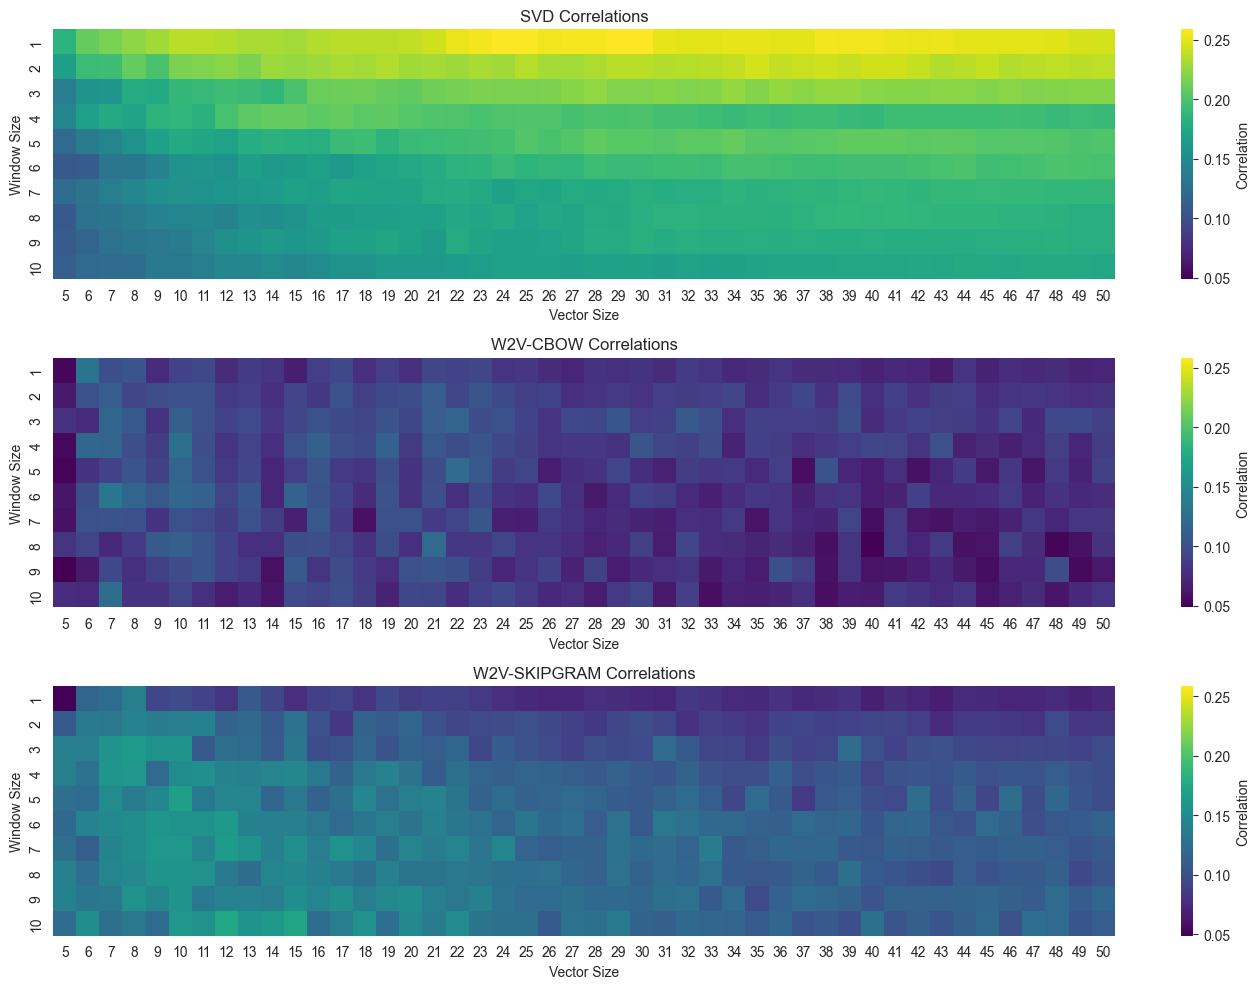

In [54]:
visualize_results(ddo_results, vector_sizes, window_sizes)

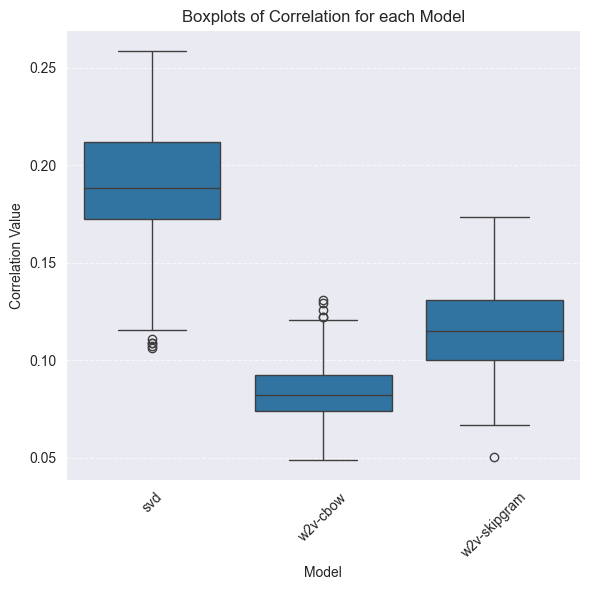

In [55]:
boxplots(ddo_results)

In [56]:
get_stats(ddo_results)

Stats for each model:
                   max       min      mean    median       std
model                                                         
svd           0.258600  0.106381  0.191373  0.188201  0.031881
w2v-cbow      0.130906  0.048784  0.083399  0.082245  0.014578
w2v-skipgram  0.173578  0.050336  0.115484  0.114754  0.022480

Stats for random correlations:
                   max       min      mean    median       std
model                                                         
svd           0.125176 -0.089836  0.042138  0.043834  0.030073
w2v-cbow      0.036857 -0.133806 -0.043122 -0.043095  0.031867
w2v-skipgram  0.090472 -0.151815 -0.040011 -0.039463  0.031456


In [57]:
closest_svd = get_closest_elements(ms_svd_ddo)
closest_w2v = get_closest_elements(ms_w2v_ddo)
closest_w2v_sg = get_closest_elements(ms_w2v_sg_ddo)

In [59]:
headers = ["Gloss", "SVD", "W2V", "W2V SG"]
rows = []
for element in closest_svd.keys():
    if closest_svd.get(element, "-")=="-" or  closest_w2v.get(element, "-")=="-" or closest_w2v_sg.get(element, "-")=="-":
        pass
    else:
        rows.append([element, closest_svd.get(element, "-"), closest_w2v.get(element, "-"), closest_w2v_sg.get(element, "-")])

# Order the rows alfabetically
rows_sorted = sorted(rows, key=lambda x: x[0])
print(tabulate(rows_sorted, headers=headers, tablefmt="grid"))


+-----------------+----------------+----------------+----------------+
| Gloss           | SVD            | W2V            | W2V SG         |
+=================+================+================+================+
| AD.ABL          | IV.PL          | APUD.ABL       | ADV            |
+-----------------+----------------+----------------+----------------+
| AD.ESS          | MSD            | SUB.ABL        | SUB.ABL        |
+-----------------+----------------+----------------+----------------+
| AD.LAT          | IN.ESS         | IN.ESS         | IN.ESS         |
+-----------------+----------------+----------------+----------------+
| AD.VERS         | INSTR          | SUPER.VERS     | SUB.LAT        |
+-----------------+----------------+----------------+----------------+
| AD.VERS.DIST    | SUPER.ABL.DIST | APUD.ABL       | CONT.ABL.DIST  |
+-----------------+----------------+----------------+----------------+
| ADV             | NEG.PRSPRT.OBL | EQU2           | POSS.ABL.DIST  |
+-----